## Description:
The dataset is comprised of tab-separated files with phrases from the IMDB Movie Ratings. The train/test split has been preserved for the purposes of benchmarking, but the sentences have been shuffled from their original order. Each Sentence has been parsed into many phrases by the Stanford parser. Each phrase has a PhraseId. Each sentence has a SentenceId. Phrases that are repeated (such as short/common words) are only included once in the data.

train.tsv contains the phrases and their associated sentiment labels. We have additionally provided a SentenceId so that you can track which phrases belong to a single sentence.

test.tsv contains just phrases. You must assign a sentiment label to each phrase. The sentiment labels are:

- 0 : negative 
- 1 : positive

## Objective:
- cleanup (if required).
- Build classification models to predict the ratings of the movie implemented using the following algorithms:
    - Logistic Regression
    - Naive Bayes
    - Random Forest
    - XGBoost
    
    ...
- Implement the above algorithms with Pyspark.
- Compare the evaluation metrics of vaious classification algorithms.

## Some Initializations

In [1]:
import os
memory = '20g'
pyspark_submit_args = '--executor-memory 4g' + ' --driver-memory ' + memory + ' pyspark-shell'
os.environ["PYSPARK_SUBMIT_ARGS"] = pyspark_submit_args

from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, NaiveBayes, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initial SparkSession
conf = SparkConf() \
    .set('spark.driver.host', '127.0.0.1') \
    .set("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.4") \
    .set("spark.sql.autoBroadcastJoinThreshold", "-1") \
    .setMaster("local").setAppName('MovieReview Sentiment Analysis')
spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

# Set matplotlib style
plt.rcParams['figure.figsize'] = [10, 6]

# Ignore warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

:: loading settings :: url = jar:file:/Applications/anaconda3/envs/CS5344/lib/python3.8/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/yangchenggang/.ivy2/cache
The jars for the packages stored in: /Users/yangchenggang/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-34f49050-0c85-4787-9323-a7ed3c6361cd;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;5.1.4 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.20.1 in central
	found com.google.guava#guava;31.1-jre in central
	found com.goo

### Loading the data

In [2]:
# Importing the dataset
df = pd.read_csv('../Datasets/movie.csv', header=0)

# Converting the dataset to spark dataframe
df = spark.createDataFrame(df)

# Showing the first 5 rows of the dataframe
# df.show(5)
# print(f'Inference: The Dataset consists of {len(df.columns)} features & {df.count()} samples.')

# Printing the schema of the dataframe
# df.printSchema()

# Checking the stats of the dataframe
# df.describe().show()


## 2. Data Preprocessing

### Checking for null values

In [3]:
from pyspark.sql.functions import col, count

# Checking for null values
null_check = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
# null_check.show()

# print('Inference: The dataset doesn\'t have any null elements' if not null_check.drop('label').toPandas().sum().sum() else '')


### Removing the duplicates

In [4]:
# remove duplicates
original_count = df.count()
df = df.dropDuplicates()

# check if duplicates are removed
# if df.count() == original_count:
#     print('Inference: The dataset doesn\'t have any duplicates')
# else:
#     print(f'Inference: Number of duplicates dropped/fixed ---> {original_count - df.count()}')


### Spark NLP pipeline

Spark NLP is a Natural Language Processing library built on top of Apache Spark ML. It provides simple, performant & accurate NLP annotations for machine learning pipelines, that scale easily in a distributed environment. We can use Spark NLP to preprocess text data, like removing stop words, normalizing text, tokenizing. In this way, we can get a clean text data for further processing.

We will be using Spark NLP pipeline to preprocess the data. The pipeline consists of the following stages:
- DocumentAssembler: Converts the input string to Spark NLP internal structure (Annotation)
- Tokenizer: Split the document into tokens (words)
- Normalizer: Transforms tokens to Normalized form (lower case, accent removal, etc.)
- Lemmatizer: Break tokens down to their root meaning to identify similar words (car, cars, car's => car)
- Stemmer: Reduce words to their root form (write, writes, writing => writ)
- Finisher: Clean up internal structures and convert to human readable output (Reverts back to text)

In [5]:
from sparknlp.base import DocumentAssembler, Finisher
from sparknlp.annotator.token.tokenizer import Tokenizer
from sparknlp.annotator.normalizer import Normalizer
from sparknlp.annotator.lemmatizer import LemmatizerModel
from sparknlp.annotator.stemmer import Stemmer
from sparknlp.annotator.stop_words_cleaner import StopWordsCleaner
from sparknlp.annotator.n_gram_generator import NGramGenerator

# Create all the required annotators
documentAssembler = DocumentAssembler() \
        .setInputCol('text') \
        .setOutputCol('document')

# Tokenize the document 
tokenizer = Tokenizer() \
        .setInputCols(['document']) \
        .setOutputCol('tokenized')

# Normalize the tokens
normalizer = Normalizer() \
        .setInputCols(['tokenized']) \
        .setOutputCol('normalized') \
        .setLowercase(True)

# Stem the normalized tokens
stemmer = Stemmer() \
        .setInputCols(['normalized']) \
        .setOutputCol('stemmed')

# Remove stopwords from the lemmatized tokens
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
eng_stopwords = stopwords.words('english')
stopwords_cleaner = StopWordsCleaner() \
        .setInputCols(['stemmed']) \
        .setOutputCol('unigrams') \
        .setStopWords(eng_stopwords)

finisher = Finisher() \
     .setInputCols(['unigrams'])


from pyspark.ml import Pipeline
# Create a pipeline
pipeline = Pipeline() \
     .setStages([documentAssembler,                  
                 tokenizer,
                 normalizer,        
                 stemmer,                  
                 stopwords_cleaner, 
                 finisher])

# Transform DataFrame
df = pipeline.fit(df).transform(df)

# Show the first 5 rows of the dataframe after filtering
# df.show(5, truncate=False)


lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[ \ ]lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
Download done! Loading the resource.
[OK!]


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yangchenggang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 4. Model Building

### Vectorizing the text data

Before we start building the models, we need to convert the text data into numerical data. We will be using TF-IDF vectorizer to convert the text data into numerical data. 

TF-IDF stands for Term Frequency-Inverse Document Frequency. It is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling.

In [6]:
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import IDF

# create a TF vectorizer
hashing_TF = HashingTF(inputCol='finished_ngrams', outputCol='tf_features')
tf_df = hashing_TF.transform(df)

# create an IDF estimator
idfizer = IDF(inputCol='tf_features', outputCol='tf_idf_features')
idf_model = idfizer.fit(tf_df)
tfidf_df = idf_model.transform(tf_df)


### Splitting the data into train and test sets

In [7]:
feature_df = tfidf_df.select(['label', 'tf_idf_features'])
# Ensure that the labels are of float type
feature_df = feature_df.withColumn("label", feature_df["label"].cast("float"))
# feature_df.show(5)

# Split the data
(train_data, test_data) = feature_df.randomSplit([0.8, 0.2], seed=0)

# Show the number of samples in each set
# print('Original set  ---> ', feature_df.count(), len(feature_df.columns))
# print('Training set  ---> ', train_data.count(), len(train_data.columns))
# print('Testing set   ---> ', test_data.count(), len(test_data.columns))

### Initializing the metrics for model evaluation

In [8]:
# Create a dictionary to store the evaluation results of each model
Evaluation_Results = {
    'Logistic Regression (LR)': [0] * 5,
    'Decision Tree Classifier (DT)': [0] * 5,
    'Random Forest Classifier (RF)': [0] * 5,
    'Naïve Bayes Classifier (NB)': [0] * 5
}

# Convert the dictionary to a pandas DataFrame
Evaluation_Results_df = pd.DataFrame(Evaluation_Results, index=['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC score']).T
Evaluation_Results_df

,Accuracy,Precision,Recall,F1-score,AUC-ROC score
Logistic Regression (LR),0,0,0,0,0
Decision Tree Classifier (DT),0,0,0,0,0
Random Forest Classifier (RF),0,0,0,0,0
Naïve Bayes Classifier (NB),0,0,0,0,0


### Defining the function for model evaluation

Classification evaluation metrics are used to access the performance of a classifier. The metrics are used to access the performance of the model on the test set. The metrics that we will be using are:
- Accuracy
- Precision
- Recall
- F1-Score
- ROC-AUC

In [9]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from sklearn.metrics import roc_curve, auc

# Classification Summary Function
def classification_summary(predictions, model_name):
    print('\nConfusion Matrix:')
    # Compute the confusion matrix
    rdd = predictions.select(['prediction', 'label']).rdd.map(tuple)    
    metrics = MulticlassMetrics(rdd)
    confusion_matrix = metrics.confusionMatrix().toArray()

    # Compute various metrics
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
    accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
    precision = confusion_matrix[1][1] / (confusion_matrix[1][1] + confusion_matrix[0][1])
    recall = confusion_matrix[1][1] / (confusion_matrix[1][1] + confusion_matrix[1][0])
    f1 = 2 * precision * recall / (precision + recall)
    
    # Compute AUC-ROC
    # Convert predictions to Pandas DataFrame
    predictions_pd = predictions.select("probability", "label").toPandas()

    # Extract the probability of the positive class
    prob_positive_class = predictions_pd.apply(lambda row: row['probability'][1], axis=1)

    # Compute FPR, TPR, and AUC-ROC
    fpr, tpr, _ = roc_curve(predictions_pd['label'], prob_positive_class)
    auc_roc = auc(fpr, tpr)

    # Update the results dataframe
    Evaluation_Results_df.loc[model_name] = [accuracy*100, precision*100, recall*100, f1*100, auc_roc*100]
    
    # Print the results
    print('{}{}\033[1m Evaluating {} \033[0m{}{}\n'.format('<'*3,'-'*35, model_name, '-'*35,'>'*3))
    print('Accuracy = {:.2f}%'.format(accuracy * 100))
    print('Precision = {:.2f}%'.format(precision * 100))
    print('Recall = {:.2f}%'.format(recall * 100))
    print('F1 Score = {:.2f}%'.format(f1 * 100))
    print('AUC-ROC = {:.2f}%'.format(auc_roc * 100))

### Logistic Regression

Logistic Regression is a classification algorithm used to assign observations to a discrete set of classes. Some of the applications of Logistic Regression are:
- Image Segmentation and Categorization
- Geographic Image Processing
- Handwriting recognition
- Healthcare: Analyzing a group of over million people for myocardial infarction within a period of 10 years is an application area of logistic regression.

Logistic Regression is a special case of Linear Regression where the target variable is categorical in nature. It uses a log of odds as the dependent variable. It basically predicts the probability of occurrence of an event by fitting data to a logit function.




Confusion Matrix:


/Applications/anaconda3/envs/CS5344/lib/python3.8/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


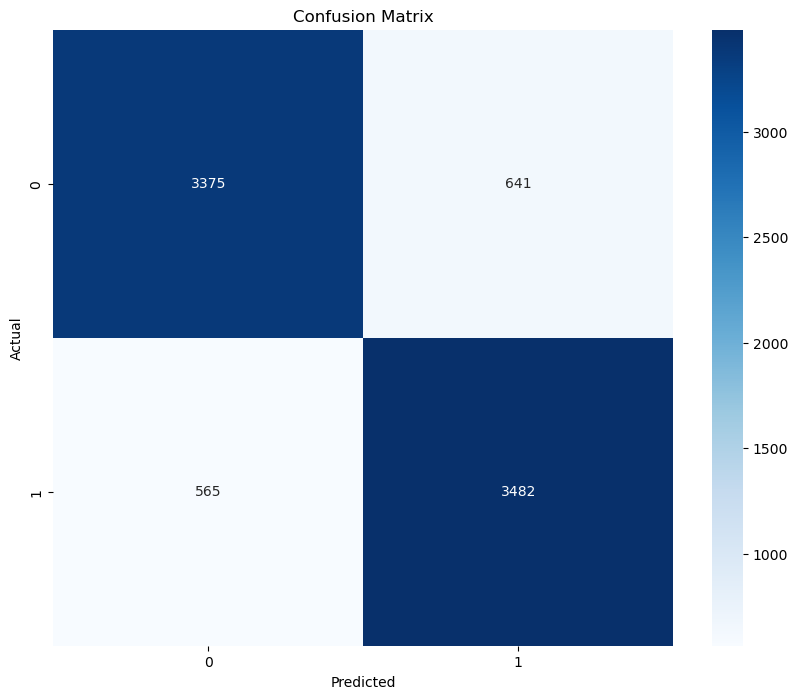

<<<----------------------------------- Evaluating Logistic Regression (LR) ----------------------------------->>>

Accuracy = 85.04%
Precision = 84.45%
Recall = 86.04%
F1 Score = 85.24%
AUC-ROC = 92.59%


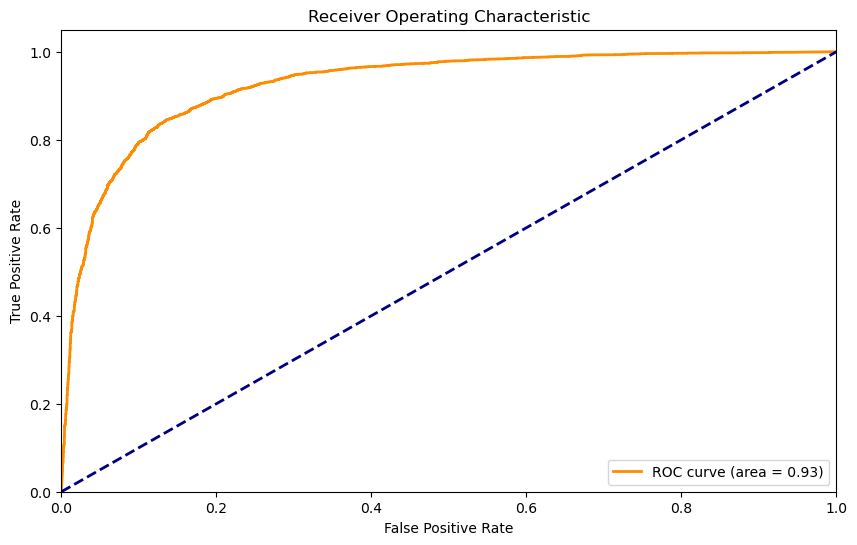

In [13]:
# Logistic Regression Classifier
lr = LogisticRegression(featuresCol="tf_idf_features", labelCol="label")
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)

# Show the results
classification_summary(lr_predictions, 'Logistic Regression (LR)')

### Naive Bayes

Naive Bayes is a classification algorithm based on Bayes’ Theorem. It is termed as ‘Naive’ because it assumes independence between every pair of feature in the data. Let’s understand the working of Naive Bayes through an example. Suppose we have a dataset of weather conditions and corresponding target variable ‘Play’ indicating whether or not the match will be played. Now, we need to classify whether players will play or not based on weather condition. Let’s follow the below steps to perform it.


Confusion Matrix:


/Applications/anaconda3/envs/CS5344/lib/python3.8/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


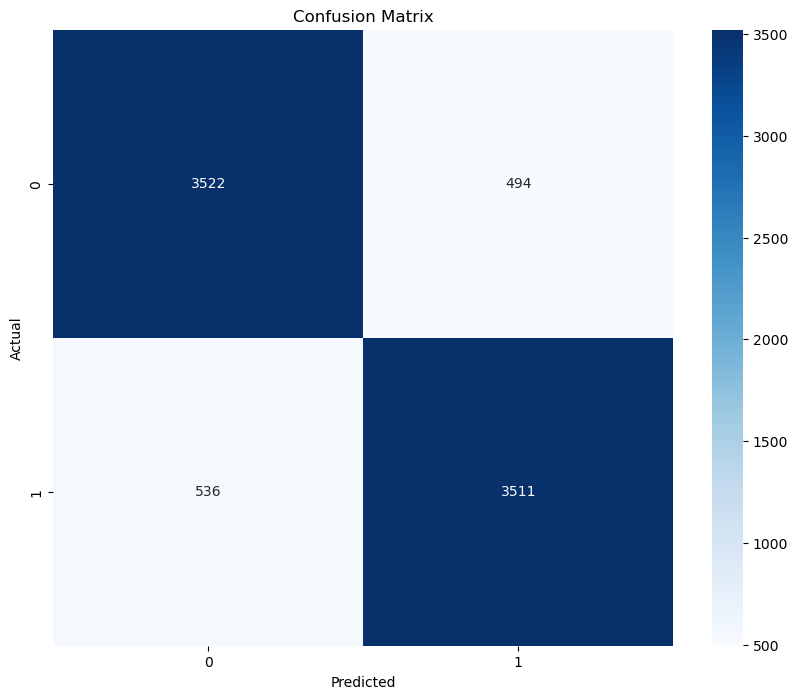

<<<----------------------------------- Evaluating Naïve Bayes Classifier (NB) ----------------------------------->>>

Accuracy = 87.23%
Precision = 87.67%
Recall = 86.76%
F1 Score = 87.21%
AUC-ROC = 92.09%


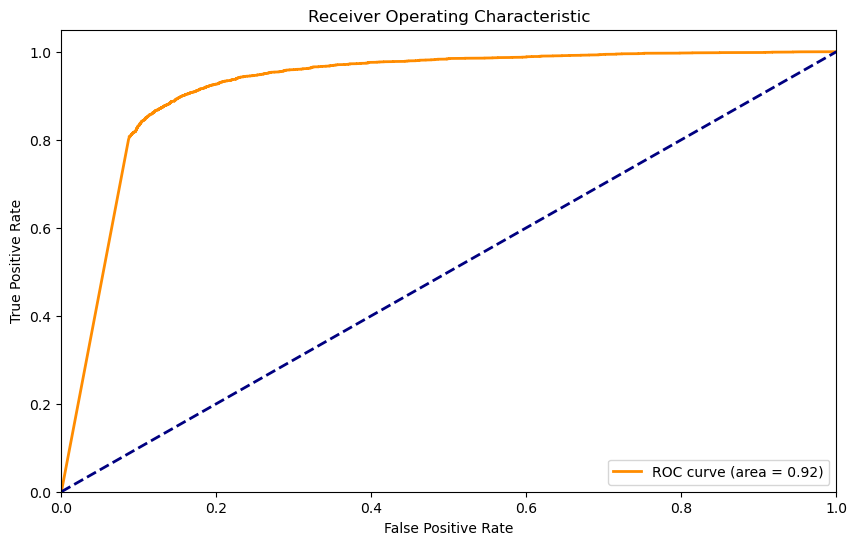

In [14]:
# Naive Bayes Classifier
nb = NaiveBayes(featuresCol="tf_idf_features", labelCol="label")
nb_model = nb.fit(train_data)
nb_predictions = nb_model.transform(test_data)

# Show the results
classification_summary(nb_predictions, 'Naïve Bayes Classifier (NB)')

### Decision Tree

Decision Tree is a basic classification and regression algorithm. It is a supervised learning algorithm that can be used for both classification and regression. And it is mostly used in classification problems. It works for both categorical and continuous input and output variables. In this algorithm, we split the population or sample into two or more homogeneous sets (or sub-populations) based on most significant splitter / differentiator in input variables.


Confusion Matrix:


/Applications/anaconda3/envs/CS5344/lib/python3.8/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


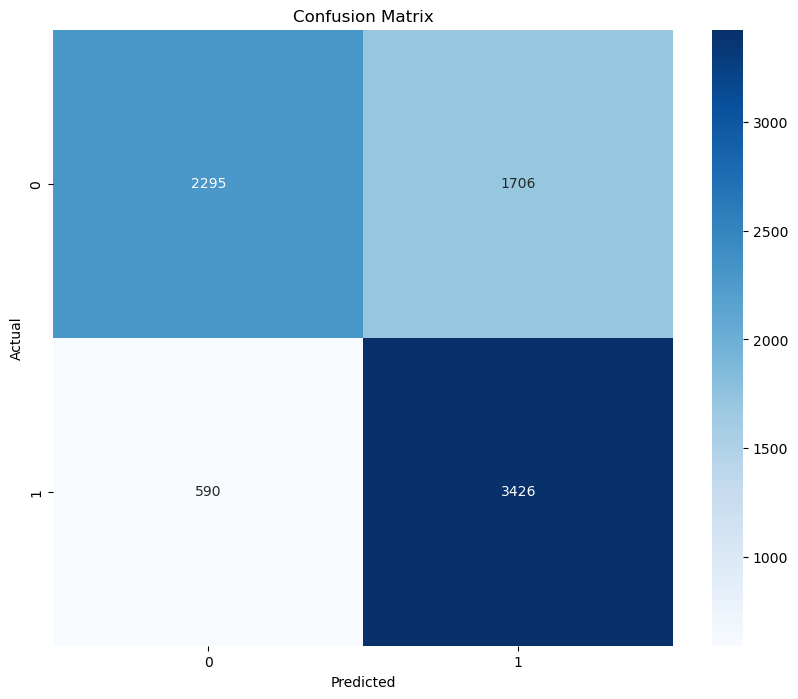

<<<----------------------------------- Evaluating Decision Tree Classifier (DT) ----------------------------------->>>

Accuracy = 71.36%
Precision = 66.76%
Recall = 85.31%
F1 Score = 74.90%
AUC-ROC = 75.95%


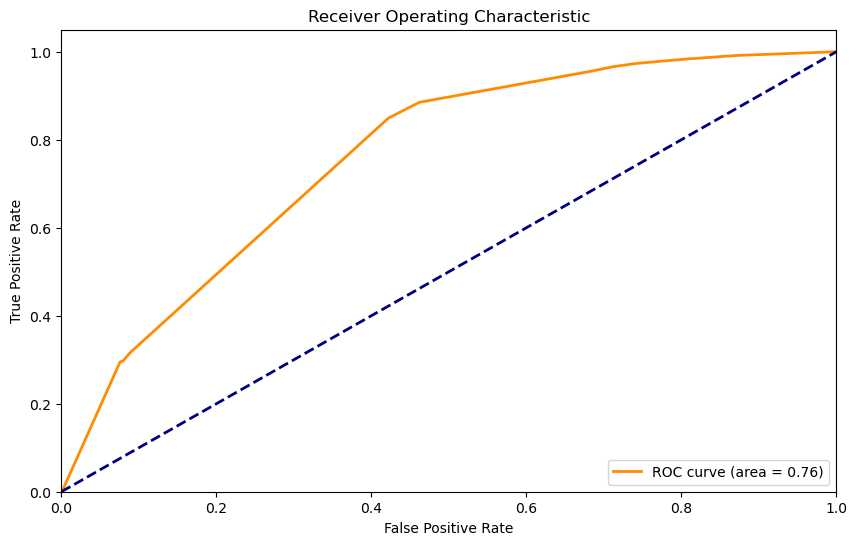

In [12]:
# Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol="tf_idf_features", labelCol="label")
dt_model = dt.fit(train_data)
dt_predictions = dt_model.transform(test_data)

# Show the results
classification_summary(dt_predictions, 'Decision Tree Classifier (DT)')

### Random Forest

Random Forest is a classic machine learning ensemble method that is a popular choice in data science. It is a type of ensemble machine learning algorithm called Bootstrap Aggregation or bagging. Bagging is a technique where a subset of the dataset is selected randomly, and a model is built on top of this subset. This model is then used to make predictions on the entire dataset. The predictions from each model are then combined using a simple majority vote (for classification) or average (for regression) to get the final prediction.


Confusion Matrix:


/Applications/anaconda3/envs/CS5344/lib/python3.8/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


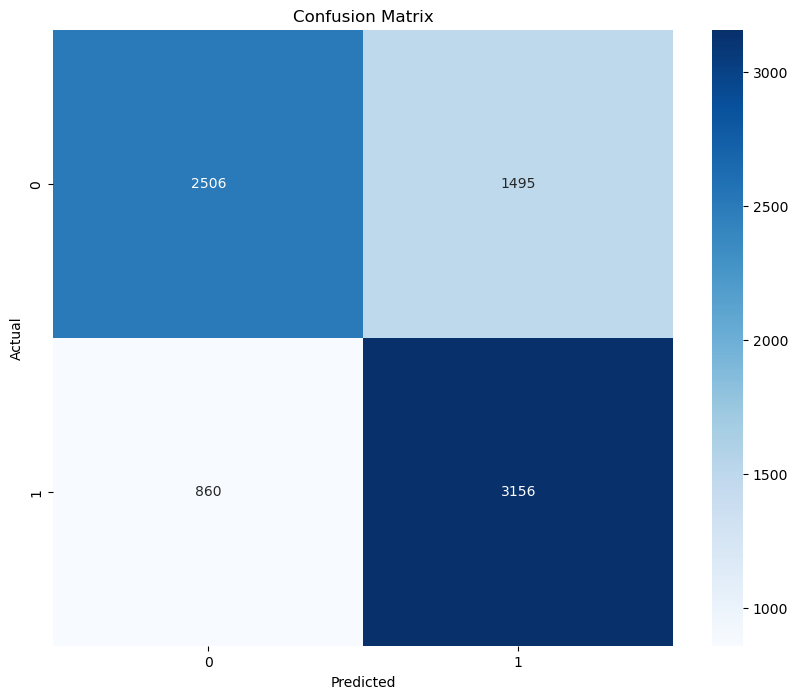

<<<----------------------------------- Evaluating Random Forest Classifier (RF) ----------------------------------->>>

Accuracy = 70.62%
Precision = 67.86%
Recall = 78.59%
F1 Score = 72.83%
AUC-ROC = 78.36%


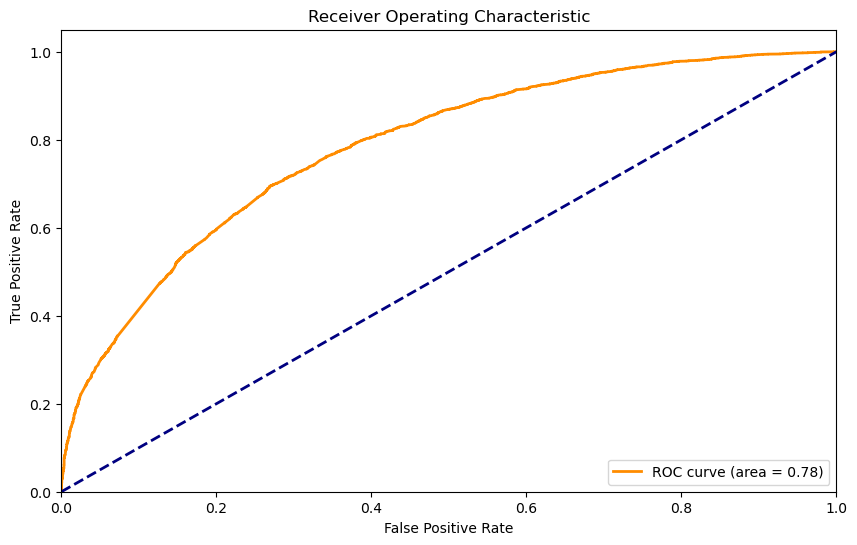

In [11]:
# Random Forest
rf = RandomForestClassifier(featuresCol="tf_idf_features", labelCol="label")
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

# # Show the results
classification_summary(rf_predictions, 'Random Forest Classifier (RF)')